In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite

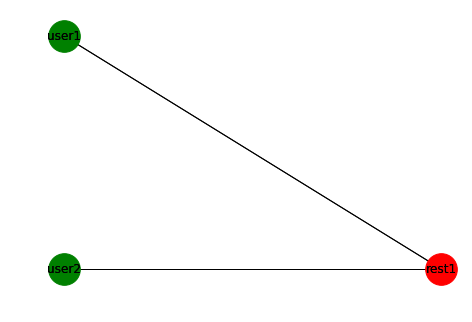

In [6]:
edge_list = [('A','P'), ('B','P'), ('C','P'), ('C','P')]
B = nx.Graph()
purple, green = ['user1', 'user2'], ['rest1']
B.add_nodes_from(purple, bipartite=0)
B.add_nodes_from(green, bipartite=1)
B.add_edges_from(edge_list)

edges = B.edges()
X, Y = bipartite.sets(B)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
nx.draw(B, pos=pos, edges=edges, nodelist=purple, with_labels=True, node_color="green", node_size=1000)
nx.draw(B, pos=pos, edges=edges, nodelist=green, with_labels=True, node_color="red", node_size=1000)
plt.show()